In [2]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns

import time

#### Read in cleaned test data and train data

In [3]:
master_train = pd.read_csv("assets/master_clean_train.csv", index_col=0)
master_test = pd.read_csv("assets/master_clean_test.csv", index_col=0)

print("master_train shape: ", master_train.shape)
print("master_test shape: ", master_test.shape)

master_train shape:  (9686, 28)
master_test shape:  (116293, 27)


#### Engineer some date features

In [4]:
def clean_dates(df):
    new_df = df.copy()
    new_df['dtdate'] = pd.to_datetime(df['dtdate'])
    new_df['month'] = new_df['dtdate'].dt.month
    new_df = pd.get_dummies(new_df, columns=['month'], drop_first=True)
    return new_df

In [5]:
master_train = clean_dates(master_train)
master_test = clean_dates(master_test)
print("master_train shape: ", master_train.shape)
print("master_test shape: ", master_test.shape)

master_train shape:  (9686, 33)
master_test shape:  (116293, 31)


In [6]:
print("Columns in input dataset: ")
print(list(master_train.columns))

Columns in input dataset: 
['address', 'block', 'street', 'trap', 'addressnumberandstreet', 'latitude', 'longitude', 'addressaccuracy', 'nummosquitos', 'wnvpresent', 'neighborhood', 'dtdate', 'species_culex_pipiens', 'species_culex_pipiens_restuans', 'species_culex_restuans', 'neighborhood_infection_category_high', 'neighborhood_infection_category_low', 'neighborhood_infection_category_medium', 'neighborhood_infection_category_none', 'park_score', 'daylight', 'avg_tavg', 'avg_preciptotal', 'avg_avgspeed', 'timelaggeddaylight', 'timelaggedtemperature', 'timelaggedprecipitation', 'timelaggedwindspeed', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10']


In [7]:
print("Columns in test dataset: ")
print(list(master_test.columns))

Columns in test dataset: 
['date', 'address', 'block', 'street', 'trap', 'addressnumberandstreet', 'latitude', 'longitude', 'addressaccuracy', 'neighborhood', 'dtdate', 'species_culex_pipiens', 'species_culex_pipiens_restuans', 'species_culex_restuans', 'neighborhood_infection_category_high', 'neighborhood_infection_category_low', 'neighborhood_infection_category_medium', 'neighborhood_infection_category_none', 'park_score', 'daylight', 'avg_tavg', 'avg_preciptotal', 'avg_avgspeed', 'timelaggeddaylight', 'timelaggedtemperature', 'timelaggedprecipitation', 'timelaggedwindspeed', 'month_7', 'month_8', 'month_9', 'month_10']


In [37]:
def output_to_kaggle(test_df, X, model, filename):
    p_array = model.predict_proba(X)
    p_series = pd.Series(p_array[:,1])
    out_df = pd.concat([test_df.index.to_series().reset_index(drop=True),p_series], axis=1)
    out_df.columns = ['Id', 'WnvPresent']
    out_df.to_csv(filename, header=True, index=False)
    return out_df

In [269]:
outfilename = r'output/kagglesubmission'+ '_' + time.strftime('%Y-%m-%d_%H-%M-%S', time.localtime()) + '.csv'
out_df = output_to_kaggle(master_test, X_test_r, custom_logreg3.model, outfilename)

### Go back to Logistic Regression

In [8]:
from sklearn.linear_model import LogisticRegression

work from https://gist.github.com/rspeare/77061e6e317896be29c6de9a85db301d

In [9]:
from sklearn import linear_model
import numpy as np
import scipy.stats as stat

class CustomLogisticRegression:
    """
    Wrapper Class for Logistic Regression which has the usual sklearn instance 
    in an attribute self.model, and pvalues, z scores and estimated 
    errors for each coefficient in 
    
    self.z_scores
    self.p_values
    self.sigma_estimates
    
    as well as the negative hessian of the log Likelihood (Fisher information)
    
    self.F_ij
    """
    
    def __init__(self,*args,**kwargs):#,**kwargs):
        self.model = linear_model.LogisticRegression(*args,**kwargs)#,**args)

    def fit(self,X,y):
        self.model.fit(X,y)
        #### Get p-values for the fitted model ####
        denom = (2.0*(1.0+np.cosh(self.model.decision_function(X))))
        F_ij = np.dot((X/denom[:,None]).T,X) ## Fisher Information Matrix
        Cramer_Rao = np.linalg.inv(F_ij) ## Inverse Information Matrix
        sigma_estimates = np.array([np.sqrt(Cramer_Rao[i,i]) for i in range(Cramer_Rao.shape[0])]) # sigma for each coefficient
        z_scores = self.model.coef_[0]/sigma_estimates # z-score for eaach model coefficient
        p_values = [stat.norm.sf(abs(x))*2 for x in z_scores] ### two tailed test for p-values
        
        self.z_scores = z_scores
        self.p_values = p_values
        self.sigma_estimates = sigma_estimates
        self.F_ij = F_ij

In [13]:
y_train = master_train['wnvpresent']

In [11]:
features = ['species_culex_pipiens',
       'species_culex_pipiens_restuans', 'species_culex_restuans',
       'park_score', 'daylight',
       'avg_tavg', 'avg_preciptotal', 'avg_avgspeed', 'timelaggeddaylight',
       'timelaggedtemperature', 'timelaggedprecipitation',
       'timelaggedwindspeed']
X_train = master_train[features]
ss = StandardScaler()
X_train_s = ss.fit_transform(X_train)

In [12]:
X_test = master_test[features].values
X_test_s = ss.transform(X_test)

In [15]:
gs_params_logreg1 = {'C': np.logspace(-2,2,11), 'penalty':['l1','l2'], 'class_weight':[None, 'balanced']}
logreg1 = LogisticRegression(random_state=0)
gs_logreg1 = GridSearchCV(logreg1, gs_params_logreg1, scoring='roc_auc', cv=3, verbose=1, n_jobs=2)

In [16]:
gs_logreg1.fit(X_train_s, y_train)

Fitting 3 folds for each of 44 candidates, totalling 132 fits


[Parallel(n_jobs=2)]: Done 102 tasks      | elapsed:   17.1s
[Parallel(n_jobs=2)]: Done 132 out of 132 | elapsed:   48.0s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=2,
       param_grid={'C': array([1.00000e-02, 2.51189e-02, 6.30957e-02, 1.58489e-01, 3.98107e-01,
       1.00000e+00, 2.51189e+00, 6.30957e+00, 1.58489e+01, 3.98107e+01,
       1.00000e+02]), 'penalty': ['l1', 'l2'], 'class_weight': [None, 'balanced']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [17]:
gs_logreg1_results = pd.DataFrame(gs_logreg1.cv_results_)

C:\Users\James\Anaconda3\envs\dsi\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\James\Anaconda3\envs\dsi\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\James\Anaconda3\envs\dsi\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\James\Anaconda3\envs\

In [18]:
gs_logreg1_results.sort_values(by='mean_test_score', ascending=False)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_C,param_class_weight,param_penalty,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
28,0.755901,0.002332,0.666752,0.809696,6.30957,None,l1,"{'C': 6.309573444801936, 'class_weight': None,...",1,0.690668,0.790639,0.673617,0.847440,0.635963,0.791008,0.016348,4.717640e-04,0.022854,0.026689
32,1.391869,0.002667,0.666657,0.809712,15.8489,None,l1,"{'C': 15.848931924611142, 'class_weight': None...",2,0.690631,0.790688,0.673718,0.847395,0.635613,0.791053,0.153225,4.724410e-04,0.023009,0.026646
36,2.172422,0.003332,0.666611,0.809717,39.8107,None,l1,"{'C': 39.810717055349734, 'class_weight': None...",3,0.690598,0.790697,0.673813,0.847383,0.635413,0.791070,0.180986,4.718773e-04,0.023097,0.026634
41,0.078955,0.002997,0.666564,0.809718,100,None,l2,"{'C': 100.0, 'class_weight': None, 'penalty': ...",4,0.690576,0.790701,0.673844,0.847380,0.635263,0.791071,0.002942,5.947204e-07,0.023161,0.026632
37,0.072292,0.002664,0.666564,0.809721,39.8107,None,l2,"{'C': 39.810717055349734, 'class_weight': None...",5,0.690537,0.790704,0.673827,0.847392,0.635317,0.791067,0.003680,4.718206e-04,0.023121,0.026638
40,2.965632,0.002665,0.666555,0.809718,100,None,l1,"{'C': 100.0, 'class_weight': None, 'penalty': ...",6,0.690594,0.790698,0.673831,0.847376,0.635231,0.791079,0.372692,4.709792e-04,0.023179,0.026629
33,0.069293,0.002998,0.666526,0.809726,15.8489,None,l2,"{'C': 15.848931924611142, 'class_weight': None...",7,0.690440,0.790694,0.673753,0.847447,0.635374,0.791037,0.001247,1.123916e-07,0.023054,0.026673
24,0.438748,0.002666,0.666517,0.809917,2.51189,None,l1,"{'C': 2.5118864315095824, 'class_weight': None...",8,0.690590,0.790434,0.672032,0.848323,0.636920,0.790996,0.014958,4.714266e-04,0.022255,0.027158
29,0.061632,0.002332,0.665866,0.809698,6.30957,None,l2,"{'C': 6.309573444801936, 'class_weight': None,...",9,0.690059,0.790644,0.672252,0.847503,0.635278,0.790945,0.004187,4.716516e-04,0.022815,0.026733
20,0.237862,0.002999,0.665558,0.809737,1,None,l1,"{'C': 1.0, 'class_weight': None, 'penalty': 'l1'}",10,0.690551,0.789838,0.668236,0.848633,0.637878,0.790739,0.013133,8.164375e-04,0.021586,0.027506


None of these hyperparameters are really making a difference in the top 10.  We'll just go with C=1, class weights = None, penalty = l1

In [20]:
custom_logreg1 = CustomLogisticRegression(random_state=0, penalty='l1',class_weight=None, tol=1e-4, C=1)
custom_logreg1.fit(X_train_s,y_train)

In [21]:
dimensional_coefs = ss.scale_ * custom_logreg1.model.coef_

In [22]:
custom_coef_df = pd.DataFrame({'Feature': ['species_culex_pipiens',
       'species_culex_pipiens_restuans', 'species_culex_restuans',
       'park_score', 'daylight',
       'avg_tavg', 'avg_preciptotal', 'avg_avgspeed', 'timelaggeddaylight',
       'timelaggedtemperature', 'timelaggedprecipitation',
       'timelaggedwindspeed'], '(Dimensional) Coef.': dimensional_coefs[0],
                               '(Non-dimensional) Coef':custom_logreg1.model.coef_.tolist()[0],
                              'p': custom_logreg1.p_values})

In [23]:
custom_logreg2.model.intercept_

array([-3.80501527])

In [24]:
custom_coef_df.sort_values(by='p')

,(Dimensional) Coef.,(Non-dimensional) Coef,Feature,p
4,-1.804593,-1.562928,daylight,7.286136e-44
8,0.677708,1.239730,timelaggeddaylight,6.465939e-31
10,-0.012888,-0.315213,timelaggedprecipitation,2.250784e-09
7,0.682302,0.271071,avg_avgspeed,5.711878e-06
11,-0.248478,-0.290134,timelaggedwindspeed,3.448055e-05
0,0.502103,1.191021,species_culex_pipiens,5.957049e-04
5,1.960562,0.259545,avg_tavg,1.254877e-03
1,0.635221,1.274247,species_culex_pipiens_restuans,1.882032e-03
6,-0.069531,-0.209992,avg_preciptotal,3.273281e-03
2,0.346240,0.774678,species_culex_restuans,3.916881e-02


All features are significant at p < 0.05, except two.

In [25]:
scores = cross_val_score(custom_logreg1.model, X_train_s, y_train, cv=5, scoring='roc_auc')

In [26]:
print('Mean of ROC AUC scores is {0:.3f}'.format(np.mean(scores)))
print('Std. dev. of ROC AUC scores is {0:.3f}'.format(np.std(scores)))

Mean of ROC AUC scores is 0.654
Std. dev. of ROC AUC scores is 0.151


#### Send output to CSV for Kaggle

In [38]:
outfilename = r'output/kagglesubmission'+ '_' + time.strftime('%Y-%m-%d_%H-%M-%S', time.localtime()) + '.csv'
out_df = output_to_kaggle(master_test, X_test_s, custom_logreg2.model, outfilename)

### Study ROC

In [27]:
from sklearn.metrics import roc_curve

In [29]:
fpr, tpr, thresholds = roc_curve(y_train.values, custom_logreg1.model.predict_proba(X_train_s)[:,1], pos_label=1)

In [32]:
sns.reset_orig()

In [33]:
t_inds = []
t_list = [0, 0.05, 0.1, 0.15, 0.2, 0.25]
for t in t_list:
    t_inds.append(np.where(thresholds>=t)[0][-1])

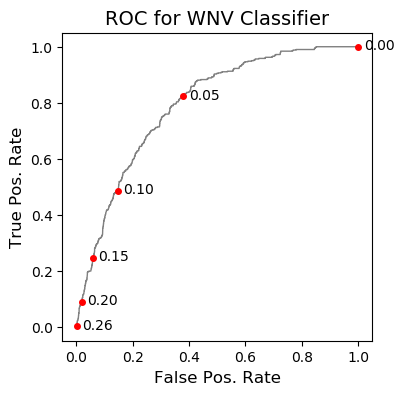

In [34]:
plt.figure(num=1, figsize=(4,4))
plt.plot(fpr,tpr, lw=1, c='gray')
plt.xlabel('False Pos. Rate',size=12)
plt.ylabel('True Pos. Rate',size=12)
plt.title('ROC for WNV Classifier', size=14)

for i in t_inds:
    plt.plot(fpr[i],tpr[i], 'o', c='red', markersize=4)
    plt.text(fpr[i]+0.02,tpr[i]-0.01, '{:.2f}'.format(thresholds[i]))

### Net Value of Spraying Policy

Net value of policy is benefit minus cost:  

B$_{P}$ - C$_{P}$ = [TPR $\cdot$ P(V) $\cdot$ (B$_{S}$ - C$_{S}$)] + [FPR $\cdot$ (1 - P(V)) $\cdot$ (0 - C$_{S}$)] 

**Terms:**  
B$_{P}$: Benefits of the spraying policy  
C$_{P}$: Costs of the spraying policy  
B$_{S}$: Benefits of using spray when/where there is virus   
C$_{S}$: Costs of using spray  
P$_{V}$: A priori probability that there is virus in a trap  
TPR: True positive rate of classifier, for a given classification threshold  
FPR: False positive rate of classifier, for a given classification threshold  

Scale the net value by the spraying cost:

(B$_{P}$ - C$_{P}$)/C$_{S}$ = [TPR $\cdot$ P$_{V}$ $\cdot$ (B$_{S}$/C$_{S}$ - 1)] - [FPR $\cdot$ (1 - P$_{V}$)]   

Scaled net value has one unknown parameter, B$_{S}$/C$_{S}$, which is the ratio of (benefit / cost)  
for an instance of spraying when there actually is virus around.  

In [35]:
def make_costbenefit_df():
    gridsize=101
    t_inds = []
    t_list = np.linspace(0,0.25,gridsize)
    for t in t_list:
        t_inds.append(np.where(thresholds>=t)[0][-1])

    apriori_proba_WNV = master_train.wnvpresent.mean()
    value_to_cost_ratios = np.logspace(0,2,gridsize)
    normalized_classifier_value = np.zeros((len(t_inds), len(value_to_cost_ratios)))
    for ind_ind, ind in enumerate(t_inds):
        for vind, vcr in enumerate(value_to_cost_ratios):
            normalized_classifier_value[ind_ind,vind] = -(fpr[ind]*(1-apriori_proba_WNV)) + \
            (tpr[ind]*apriori_proba_WNV)*(vcr-1)
    cols = ['{:.2f}'.format(v) for v in value_to_cost_ratios]
    index_keys = ['{:.2f}'.format(t) for t in thresholds[t_inds]]         
    
    return pd.DataFrame(normalized_classifier_value, columns=cols, index=index_keys)

In [41]:
costbenefit_df = make_costbenefit_df()

In [42]:
y = [float(v) for v in costbenefit_df.index.tolist()]
x = [float(v) for v in costbenefit_df.columns.tolist()]
X, Y = np.meshgrid(x,y)
Z = costbenefit_df.values

C:\Users\James\Anaconda3\envs\dsi\lib\site-packages\matplotlib\contour.py:967: UserWarning: The following kwargs were not used by contour: 'text'
  s)


Text(0.5,1,'Scaled Net Value of Policy')

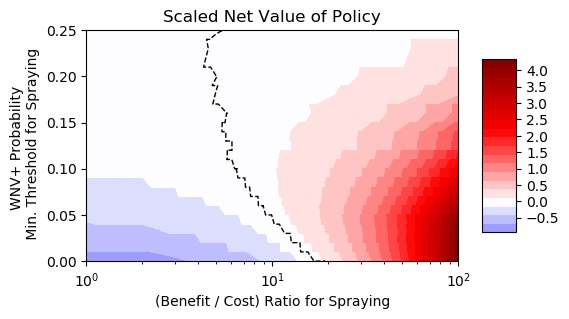

In [43]:
N_levels = 21
levels = np.linspace(np.min(Z), np.max(Z),N_levels)
plt.figure(num=1, figsize=(6,3))
plt.contourf(X,Y,Z, levels = levels, cmap = 'seismic', vmin=-np.max(np.abs(Z)),
             vmax=np.max(np.abs(Z)))
plt.colorbar(aspect=5, shrink=0.75, ticks=np.linspace(-0.5,4,10))
plt.contour(X,Y,Z, levels = [0], cmap=None, colors='black', linewidths=1, linestyles='dashed', text='asd')
plt.xscale('log')
plt.ylim(0,0.25)
plt.xlabel('(Benefit / Cost) Ratio for Spraying')
plt.ylabel('WNV+ Probability \n Min. Threshold for Spraying')
plt.title('Scaled Net Value of Policy')

Text(0.5,1,'Scaled Net Value of Policy')

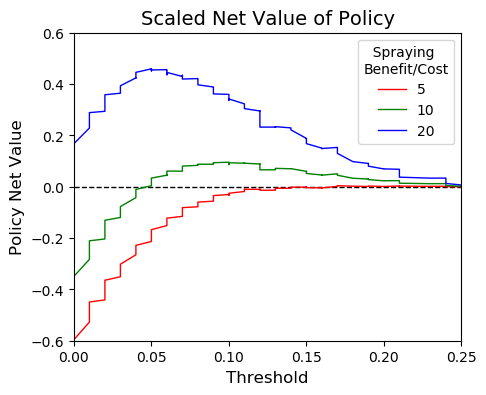

In [44]:
plt.figure(num=2, figsize=(5,4))
plt.plot([float(x) for x in costbenefit_df.index.tolist()],
         costbenefit_df['5.25'].values, c='r', lw=1,label='5')
plt.plot([float(x) for x in costbenefit_df.index.tolist()],
         costbenefit_df['10.00'].values, c='g',lw=1,label='10')
plt.plot([float(x) for x in costbenefit_df.index.tolist()],
         costbenefit_df['19.95'].values, c='b',lw=1, label='20')
plt.legend(loc='upper right', title='  Spraying\nBenefit/Cost', fontsize=10)
plt.xlim(0,0.25)
plt.ylim(-0.6,0.6)
plt.hlines(0,0,0.25, lw=1, linestyle='dashed')
plt.xlabel('Threshold',fontsize=12)
plt.ylabel('Policy Net Value',fontsize=12)
plt.title('Scaled Net Value of Policy',fontsize=14)